In [37]:
import numpy as np
import os
import matplotlib.pyplot as plt
from music21.midi import MidiFile, MetaEvents, getNumber, ChannelVoiceMessages
from music21.midi.translate import getTimeForEvents

from IPython.display import display
import librosa

from modules.midiscoretools import loadBitmap, midi_to_bitmap, Frame

<span style="color:#800000;  font-size: 16px; font-weight: bold;  ">PARAMETERS</span>

In [52]:
# defaults
refFolder="RefData/"
varFolder = "VarData/"
fps=44100/512 # fps for our mel spectrogram
sample_rate=22050
f_min=20  # Set this to your desired minimum frequency
f_max=sample_rate / 2  # Set this to your desired maximum frequency (we don't need freqs above 10K)
hop_length=256


# SETTABLE parameters
rootfolder="scores/BartokRFD1/"
score="BartokRFD1"
variation="V01/"
vtag="v01" 


<span style="color:#800000;  font-size: 16px; font-weight: bold;  ">utilities</span>

In [79]:
# get the range of used rows from a midi score bitmap
def getlowhimidinotes(matrix) :# Find rows that contain at least one '1'
    rows_with_ones = np.any(matrix == 1, axis=1)

    # Get the lowest row index with a '1'
    lowest_row_index = np.argmax(rows_with_ones)

    # Get the highest row index with a '1'
    # Use len(matrix) - 1 - argmax of the reversed array to get the last '1'
    highest_row_index = len(rows_with_ones) - 1 - np.argmax(rows_with_ones[::-1])

    return lowest_row_index, highest_row_index
    
#######################################################
def midi_to_note_name(midi_note):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = midi_note // 12 - 1
    return f"{note_names[midi_note % 12]}{octave}"
    
#######################################################
def plot_midi_matrix(bmframes, minp=0, maxp=127, figsize=(20, 5)):
    if minp is None or maxp is None:
        minp, maxp = getlowhimidinotes(bmframes)
    
    plt.figure(figsize=figsize)
    subset_matrix = bmframes[minp:maxp+1, :]
    plt.imshow(subset_matrix, origin='lower', aspect='auto')
    
    yticks = np.arange(0, subset_matrix.shape[0], 6)
    ytick_labels = np.arange(minp, maxp+1, 6)
    plt.yticks(yticks, ytick_labels)
    
    for i, label in enumerate(ytick_labels):
        plt.text(-150, yticks[i], f'{midi_to_note_name(ytick_labels[i])}', va='center', ha='right', color='blue')
    
    plt.tight_layout()
    plt.show()

#########################################################
def plot_mel_matrix(mel_spec, sr=sample_rate, f_min=f_min, f_max=f_max, hop_length=hop_length, figsize=(10, 5)) :
    # mel bins
    n_mels = mel_spec.shape[0]
    
    # Calculate mel frequencies
    mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=f_min, fmax=f_max)
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
    
    # Set y-axis labels
    plt.yticks(np.arange(0, n_mels, 10), [f'{int(f)}' for f in mel_frequencies[::10]])
    plt.ylabel('Frequency (Hz)')
    
    # Set x-axis labels
    time_ticks = np.linspace(0, mel_spec.shape[1], 5)
    time_labels = [f'{t:.1f}' for t in time_ticks * hop_length / sr]
    plt.xticks(time_ticks, time_labels)
    plt.xlabel('Time (s)')
    
    plt.title('Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

#############################################################################
def plot_dtw(values, figsize=(10, 10), max_points=1000):
    # Calculate max values
    max_x = len(values) - 1
    max_y = max(values)
    
    # Create figure with aspect ratio based on list length and max value
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect(max_x / max_y)
    
    # Reduce number of points if necessary
    if len(values) > max_points:
        indices = np.linspace(0, len(values) - 1, max_points, dtype=int)
        x_values = indices
        y_values = [values[i] for i in indices]
    else:
        x_values = range(len(values))
        y_values = values
    
    # Plot the values with a thin line
    ax.plot(x_values, y_values, linewidth=0.5, color='blue', marker=',', markersize=1)
    
    # Plot the diagonal dotted line
    ax.plot([0, max_x], [0, max_y], 'r:', alpha=0.7, linewidth=0.5)
    
    # Set limits
    ax.set_xlim(0, max_x)
    ax.set_ylim(0, max_y)
    
    # Set ticks
    x_ticks = np.linspace(0, max_x, 10, dtype=int)
    y_ticks = np.linspace(0, max_y, 10)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    
    # Format y-tick labels to avoid scientific notation
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Labels
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Dynamic Time Warping Plot')
    
    # Grid
    ax.grid(True, linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


<div style="text-align:center; margin: 2px 0;">
    <h2 style="display:inline-block; padding: 0 10px; font-family: 'Brush Script MT', cursive; font-size: 16px; color:#1e90ff;">
        ✿ ✿ ✿ ✿ ✿ ✿ ✿ ✿ ✿
        <span style="color:#800000; font-family: 'Georgia', serif; font-size: 18px; font-weight: bold; padding: 0 15px;">Reference Data</span>
        ✿ ✿ ✿ ✿ ✿ ✿ ✿ ✿ ✿
    </h2>
</div>

<span style="color:#800000;  font-size: 16px; font-weight: bold;  ">location info</span>

In [4]:
import json
with open(rootfolder+refFolder+score+ '.locinfo.jsn', 'r') as f:
    data = json.load(f)
time_positions = data['time-positions']
print(f'time, measure, beat')
print(f'{time_positions[:10]}')
print(f'...')
print(f'{time_positions[-10:]}')

time, measure, beat
[[0, 0, 1], [0.312, 1, 1], [0.468, 1, 1.25], [0.625, 1, 1.5], [0.937, 1, 2], [1.25, 1, 2.5], [1.562, 2, 1], [1.718, 2, 1.25], [1.875, 2, 1.5], [2.187, 2, 2]]
...
[[55.937, 45, 2], [56.25, 45, 2.5], [56.562, 46, 1], [56.875, 46, 1.5], [57.187, 46, 2], [57.5, 46, 2.5], [57.812, 47, 1], [58.437, 47, 2], [59.062, 48, 1], [59.687, 48, 2]]


<span style="color:#800000;  font-size: 16px; font-weight: bold;  ">plot reference midi bitmap</span>

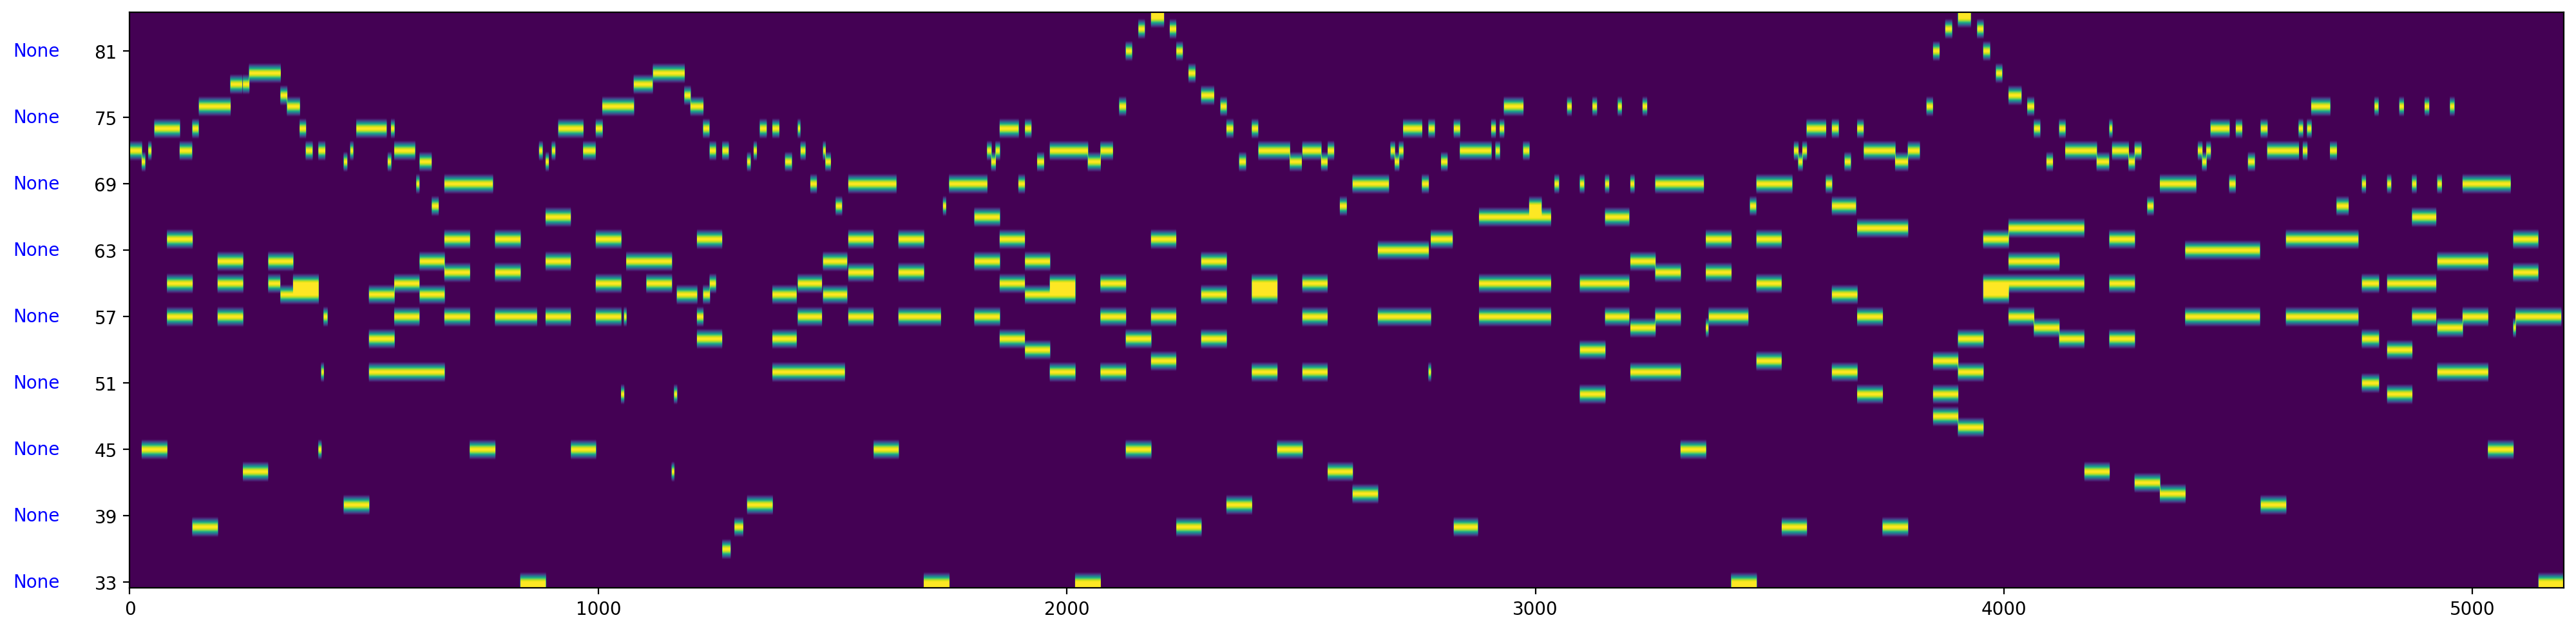

bitmap shape is (128, 5195)


In [33]:
bmframes=loadBitmap(rootfolder+refFolder+score+'.bm.npz')
minp=0
maxp=127
# (Optionally) estrict image to range of notes actually used. 
if True: 
    minp, maxp = getlowhimidinotes(bmframes)
plot_midi_matrix(bmframes, minp=minp, maxp=maxp, figsize=(20, 5))
print(f'bitmap shape is {bmframes.shape}')

<span style="color:#800000;  font-size: 16px; font-weight: bold;  ">Show reference frames</span>

In [10]:
refFrameList=Frame.load_frames(rootfolder+refFolder+score+'.frames.npz')

for x in refFrameList[0:5]:
    display(x.print_short())
print(f'...')
for x in refFrameList[-5:]:
    display(x.print_short())

'(0, mTk=4.000, mTm=0.006, measure=0.000, beat=1.000)'

'(1, mTk=13.000, mTm=0.017, measure=0.000, beat=1.038)'

'(2, mTk=22.000, mTm=0.029, measure=0.000, beat=1.075)'

'(3, mTk=31.000, mTm=0.041, measure=0.000, beat=1.113)'

'(4, mTk=40.000, mTm=0.052, measure=0.000, beat=1.150)'

...


'(5191, mTk=46289.000, mTm=60.273, measure=48.000, beat=2.948)'

'(5192, mTk=46298.000, mTm=60.285, measure=48.000, beat=2.967)'

'(5193, mTk=46307.000, mTm=60.296, measure=48.000, beat=2.985)'

'(5194, mTk=46316.000, mTm=60.308, measure=48.000, beat=1.004)'

'(5195, mTk=46325.000, mTm=60.320, measure=48.000, beat=1.023)'


<div style="text-align:center; margin: 2px 0;">
    <h2 style="display:inline-block; padding: 0 10px; font-family: 'Brush Script MT', cursive; font-size: 16px; color:#1e90ff;">
        ✿ ✿ ✿ ✿ ✿ ✿ ✿ ✿ ✿
        <span style="color:#800000; font-family: 'Georgia', serif; font-size: 18px; font-weight: bold; padding: 0 15px;">Variation Data</span>
        ✿ ✿ ✿ ✿ ✿ ✿ ✿ ✿ ✿
    </h2>
</div>

frames.shape is {frames.shape}


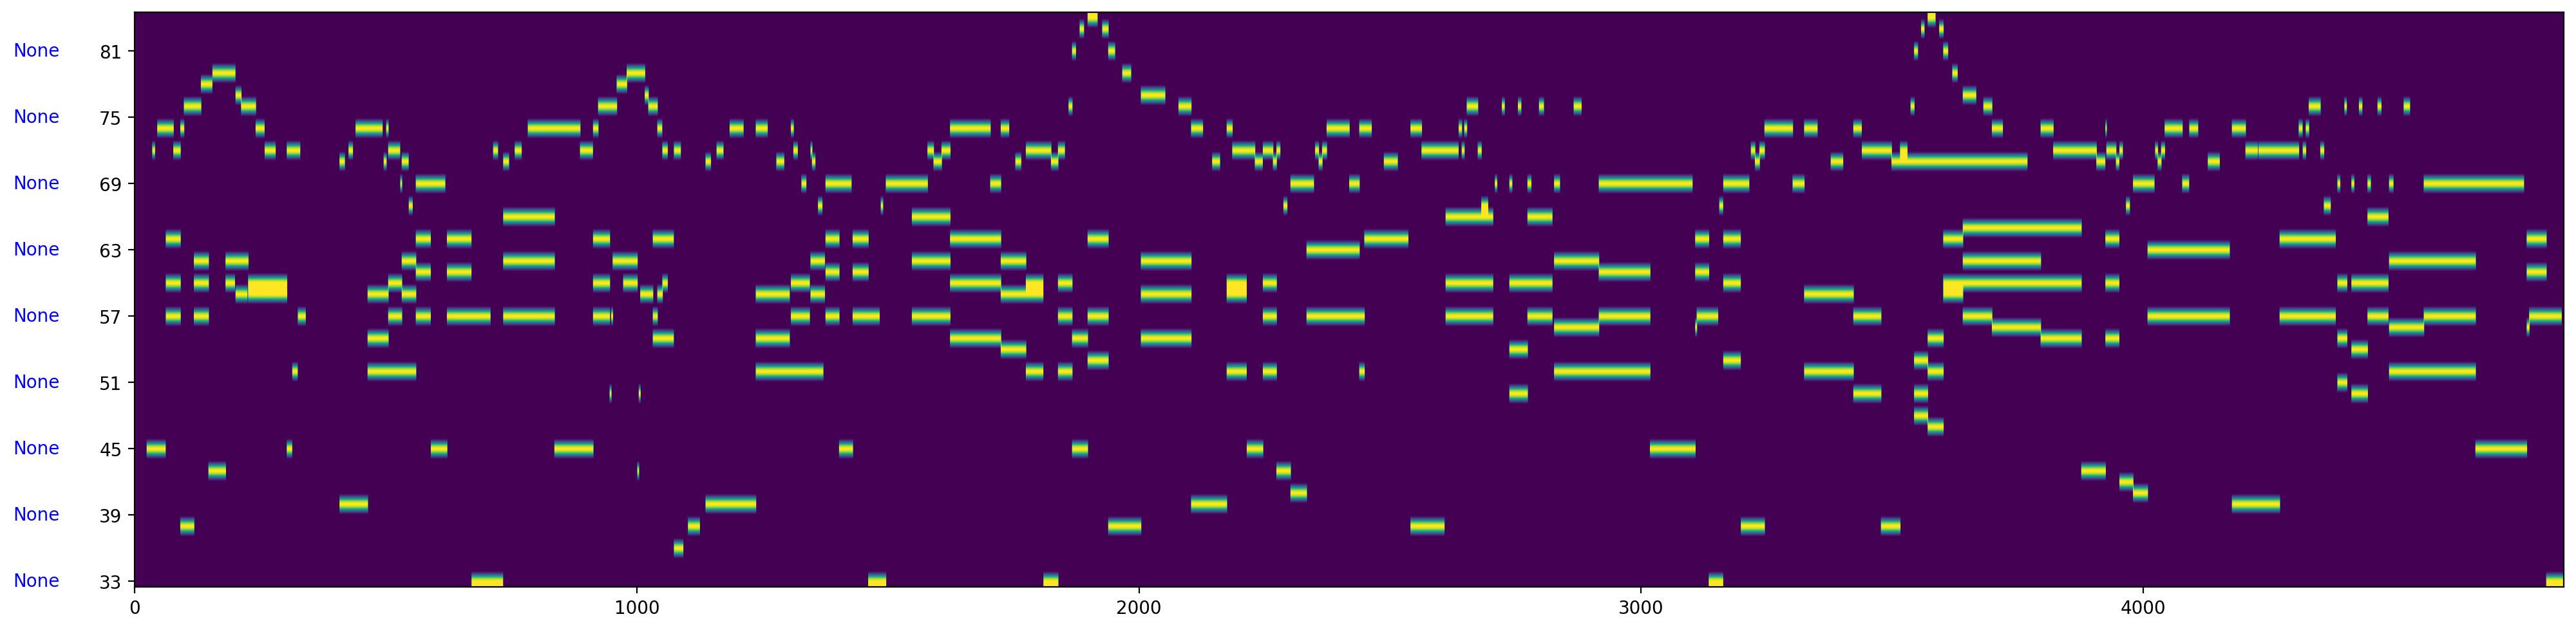

bitmap shape is (128, 4838)


In [35]:
# We don't actually have a bitmap for the variation since we dont
# need it for training the NN. But we can make one here on the fly just to visualize it:
midi_file= rootfolder+varFolder+variation+score+vtag+'.mid'
varbmframes, minp, maxp = midi_to_bitmap(midi_file, fps) #same fps as our mel spectrogram
plot_midi_matrix(varbmframes, minp=minp, maxp=maxp, figsize=(20, 5))
print(f'bitmap shape is {varbmframes.shape}')

In [31]:
bmframe.shape

(128, 4838)

In [54]:
# Load the .npz file
loaded_data = np.load(rootfolder+varFolder+variation+score+vtag+".mel.npz")
# Extract the matrix
spec_db = loaded_data['data']

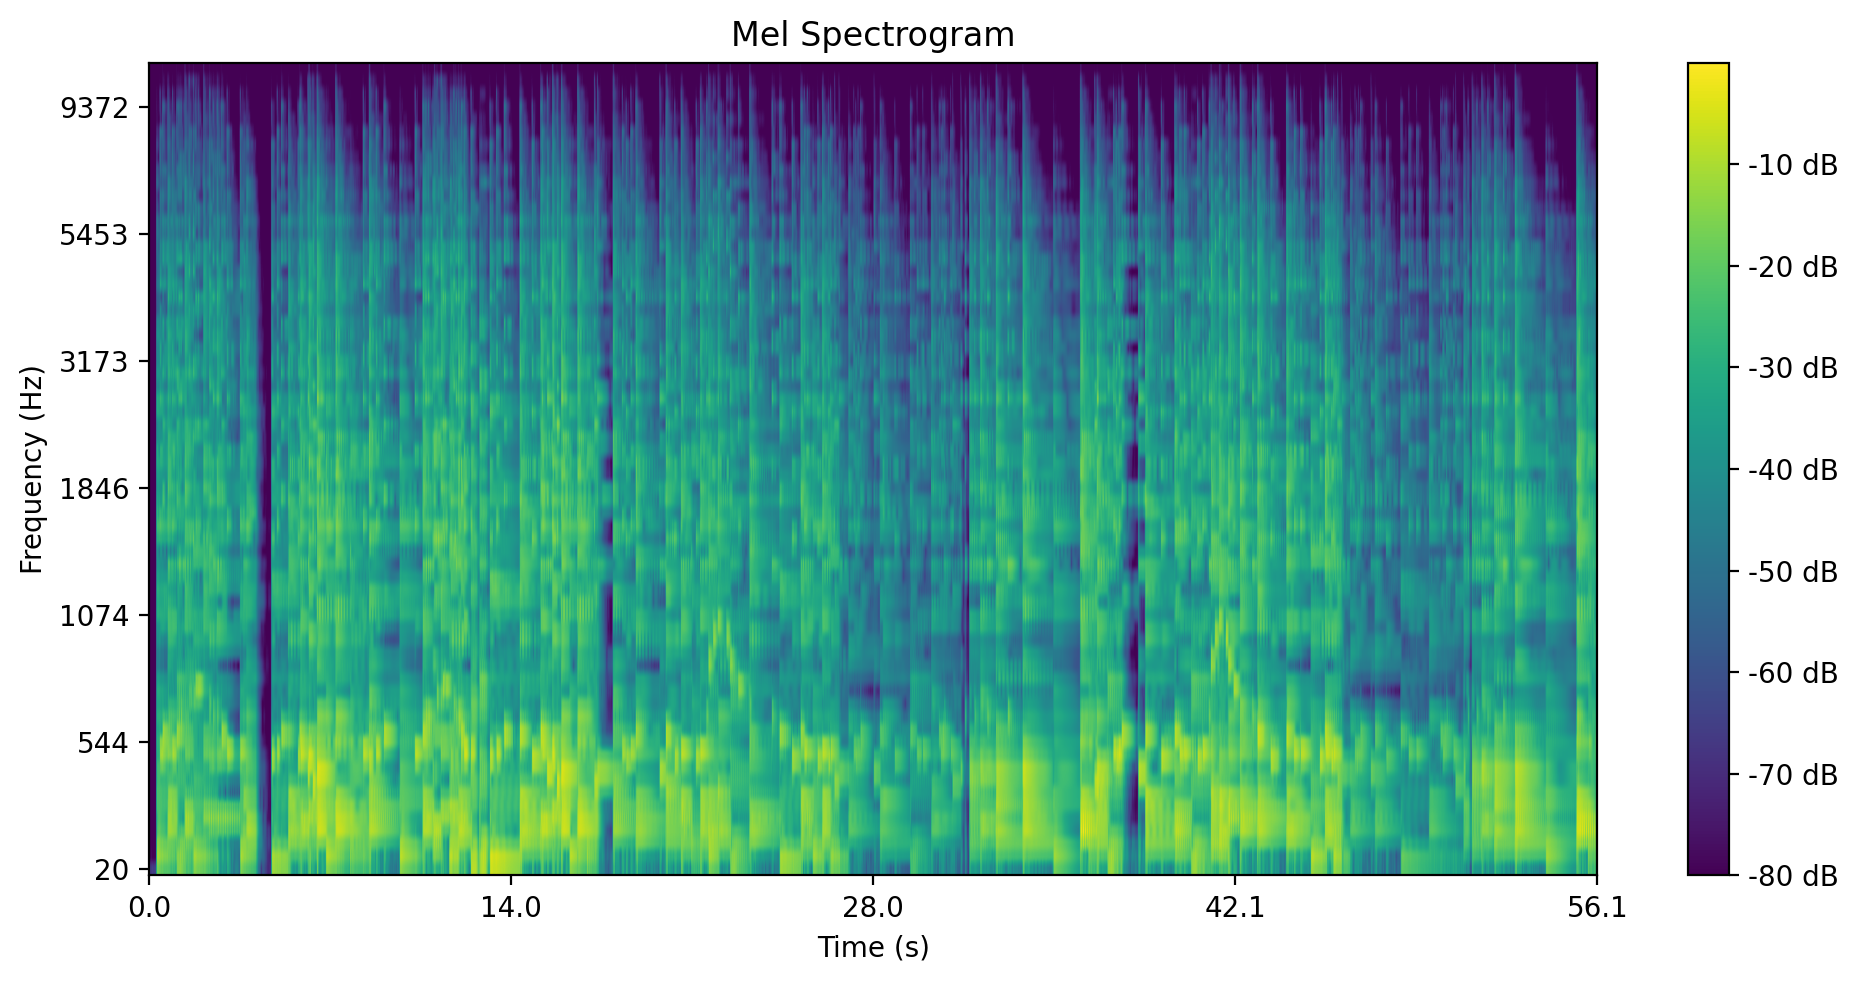

spec_db shape is (64, 4832)


In [58]:
plot_mel_matrix(spec_db)
print(f'spec_db shape is {spec_db.shape}')

In [62]:
varFrameList=Frame.load_frames(rootfolder+varFolder+variation+score+'framesout.npz')

In [75]:
dtw=[x.refframe for x in varFrameList]

In [76]:
len(dtw)

2433

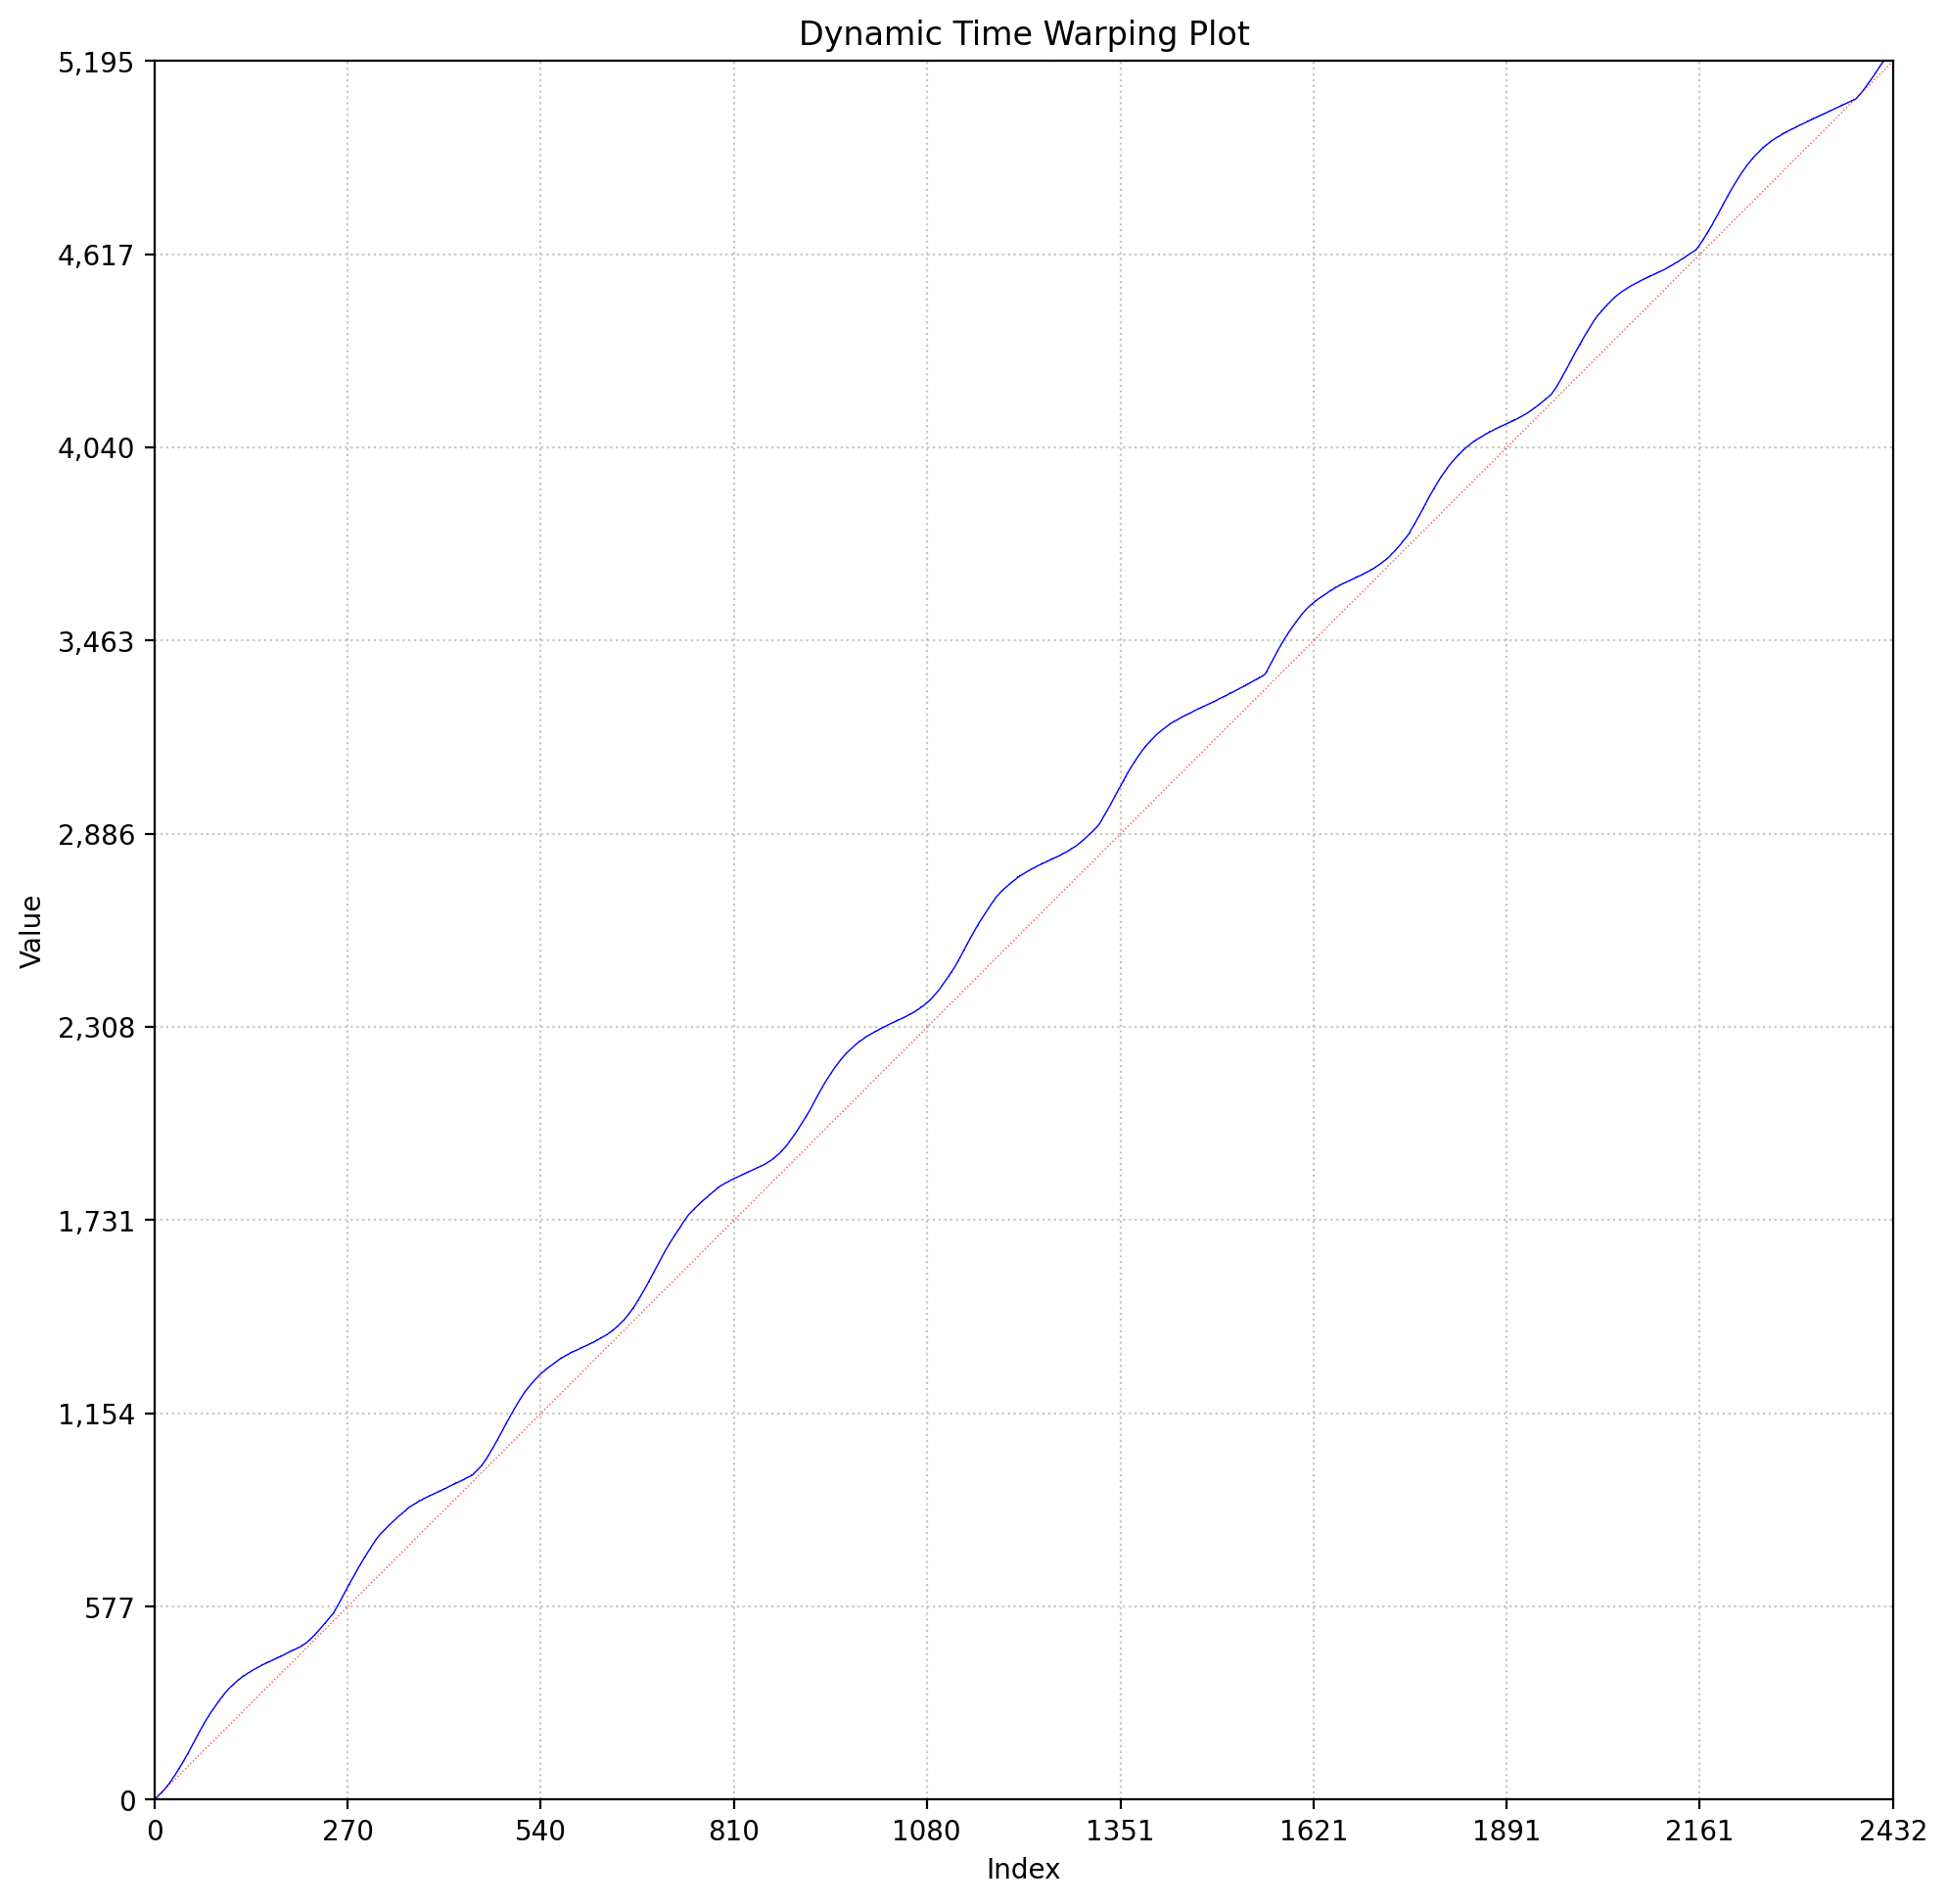

In [80]:
plot_dtw(dtw)